# Data 512 Project
## FIFA transfer market analysis of the top 5 European leagues 

## Introduction

## 1. Data Collection


#### Data is scraped off of transfermarket.co.uk in accordance with their Terms of Use. 
#### The R scripts to scrape data are stored under scrapingScripts/, run the following cell to generate raw data
``` R < scriptName.R --no-save  ```

### 1.1 Run R scripts to scrape data

In [11]:
!R < ./scrapingScripts/01-scrape.R --no-save


R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin15.6.0 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> 
> # setup -------------------------------------------------------------------
> getwd()
[1] "/Users/tharun/workspace/data-512/data-512-project"
> # load packages / local functions
> source("./scrapingScripts/00-setup.R")
Loading required package: pacman
> 
> # seasons to scrape
> seasons <- c(201

#### scrape.R can be modified to include more seasons and leagues, by default we are considering the years 1991-2018 and the European leagues from England, Spain, Italy, France, Germany, (Top 5) , Portugal and Netherlands

### 1.2 List first 5 files in data directory

In [304]:
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk("./rawData"):
    f.extend(filenames)
    break
f[0:5]

['spanish_primera_division_2018.csv',
 'english_championship_1991.csv',
 'italian_serie_a_2000.csv',
 'italian_serie_a_2014.csv',
 'german_bundesliga_1_2018.csv']

### 1.3 Combining data into one file

In [305]:
import pandas as pd
import glob

interesting_files = glob.glob("./rawData/*.csv") 

# Combine data frames inside rawData directory
combinedDf = pd.concat((pd.read_csv(f, header = 0) for f in interesting_files))

In [306]:
combinedDf.to_csv("./cleanData/allSeasons.csv")
combinedDf.head(5)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,nat,fee_cleaned,league_name,year,season
0,Athletic Bilbao,Yuri Berchiche,28.0,Left-Back,Paris SG,£21.60m,in,Spain;,21.60,Primera Division,2018,2018/2019
1,Athletic Bilbao,Ibai Gómez,29.0,Right Winger,Alavés,£3.60m,in,Spain;,3.60,Primera Division,2018,2018/2019
2,Athletic Bilbao,Ander Capa,26.0,Right-Back,SD Eibar,£2.70m,in,Spain;,2.70,Primera Division,2018,2018/2019
3,Athletic Bilbao,Cristian Ganea,26.0,Left-Back,FC Viitorul,£900k,in,Romania;Spain;,0.90,Primera Division,2018,2018/2019
4,Athletic Bilbao,Kenan Kodro,25.0,Centre-Forward,FC Copenhagen,£810k,in,Bosnia-Herzegovina;Spain;,0.81,Primera Division,2018,2018/2019


## 2. Data Pre-Processing

In [307]:
import pandas as pd
import numpy as np
raw = pd.read_csv("./cleanData/allSeasons.csv")

#### Shape of the dataset

In [308]:
raw.shape

(147027, 13)

#### Columns

In [309]:
raw.columns

Index(['Unnamed: 0', 'club_name', 'player_name', 'age', 'position',
       'club_involved_name', 'fee', 'transfer_movement', 'nat', 'fee_cleaned',
       'league_name', 'year', 'season'],
      dtype='object')

### 2.1 Dropping unnecessary columns

In [310]:
raw.head(5)
raw = raw.drop(["player_name","age","fee"],axis=1)

### 2.2 Clean up nationality and position
#### For players belonging to more than one nation, only the first country is used
#### Positions are generalized into Forwards, Midfield, Defense, Wingers and Goalkeepers


In [311]:
# Consider only the first country that player belongs to
def cleanCountry(row):
    if isinstance(row["nat"],str) :
        return row["nat"].split(";")[0]
    else:
        return row["nat"]
    
# Replace positions with a general category    
def cleanPosition(row):
    if isinstance(row["position"],str) :
        if "Midfield" in row["position"]:
            return "Midfield"
        elif row["position"].find("Back")>-1:
            return "Defense"
        elif "Forward" in row["position"]:
            return "Forward"
        elif "Striker" in row["position"]:
            return "Forward"    
        elif "Winger" in row["position"]:
            return "Winger"
        else:
            return row["position"]
    else:
        return row["position"]

<b>Clean up country  
Clean up position and add new posNew column  
Remove incoming transfers (duplicates)  
Remove rows from Championship, we're only considering top flight leagues  </b>

In [312]:
# Clean up country
raw["nat"] = raw.apply(cleanCountry,axis=1)
# Clean up Position aand add new posNew column
raw["posNew"] = raw.apply(cleanPosition,axis=1)
# Remove incoming transfers (duplicates)
raw = raw[raw['transfer_movement']=='in']
# Remove rows from Championship, we're only considering top flights leagues
raw = raw[raw["league_name"]!="Championship"]

### 2.4 Replace NA's with zeroe's and drop all rows with zeroe's

#### For the purposes of this analysis we will be only considering publicly stated transfers. Transfers involving loans, free transfers and end of contract signings are not considered.

In [313]:
# Replace 0's with NA's and drop rows  
raw = raw.replace(0,np.nan)
raw = raw.dropna()
leagues = raw.league_name.unique()

In [314]:
raw.to_csv("./cleanData/allSeasonsClean.csv")
raw.shape

(12583, 11)

### 2.5. Load data into SQL Server

<b>For all future parts of this analysis a local installation of sqlite3 is recommended. Download sqlite3 from the following link and unzip the file https://www.sqlite.org/download.html. </b>

<b>
We will be using an in-memory database to run SQL queries against. If you would like to create a persistent copy of the database, replace :memory: with a path in the filesystem
</b>

In [320]:
import sqlite3
import pandas as pd

# Create a new database called transfers.db
raw = pd.read_csv("./cleanData/allSeasonsClean.csv")
cnx = sqlite3.connect(":memory:")

# create the dataframe from a query
raw.to_sql("transfer", cnx, if_exists='append', index=False)

#### Verifying counts in database

In [322]:
df = pd.read_sql_query("SELECT count(*) FROM transfer limit 1", cnx)
df.head()

,count(*)
0,12583


#### Loading inflation dataset

<b>British inflation data is obtained from http://inflation.iamkate.com/ under the <insert license here></b>
    
<b>Multiplier mentions by how much the price at a particular year should be multiplied by to get an inflation adjusted value</b>

In [323]:
inflation = pd.read_csv("./cleanData/inflation.csv")
inflation.head()

,Year,Multiplier
0,2018,1.00
1,2017,1.04
2,2016,1.05
3,2015,1.07
4,2014,1.09


In [324]:
inflation.to_sql("inflation", cnx, if_exists='append', index=False)

### 2.6. Adjust transfer fee for inflation

<b>Adjust transfer fees for inflation and store this data as transfers table</b>

In [325]:
inflation_adjusted = pd.read_sql_query("select transfer.*,(fee_cleaned*multiplier) as `fee_inflation_adjusted` from transfer join inflation on transfer.year = inflation.year",cnx)
inflation_adjusted.to_sql("transfers", cnx, if_exists='append', index=False)


## 3. Data Analysis

#### Verifying data in the table

In [326]:
pd.read_sql_query("SELECT count(*) FROM transfers limit 1", cnx).head()

,count(*)
0,12583


## Q1. How has the transfer spending increased in the top 5 European Leagues?

### SQL query - sum(transfer_fee) and group by league_name and year


In [327]:
df = pd.read_sql_query("SELECT league_name,year,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       league_name in ('Serie A', '1 Bundesliga', 'Premier League', 'Ligue 1','Primera Division') \
                       group by league_name,year",cnx)
df.head(5)

,league_name,year,total_spending in £million
0,1 Bundesliga,1991,63.91224
1,1 Bundesliga,1992,53.74992
2,1 Bundesliga,1993,65.19518
3,1 Bundesliga,1994,93.10642
4,1 Bundesliga,1995,130.20399


### Plot

Text(0.5, 1.0, 'Transfer Spending in the top 5 European Leagues')

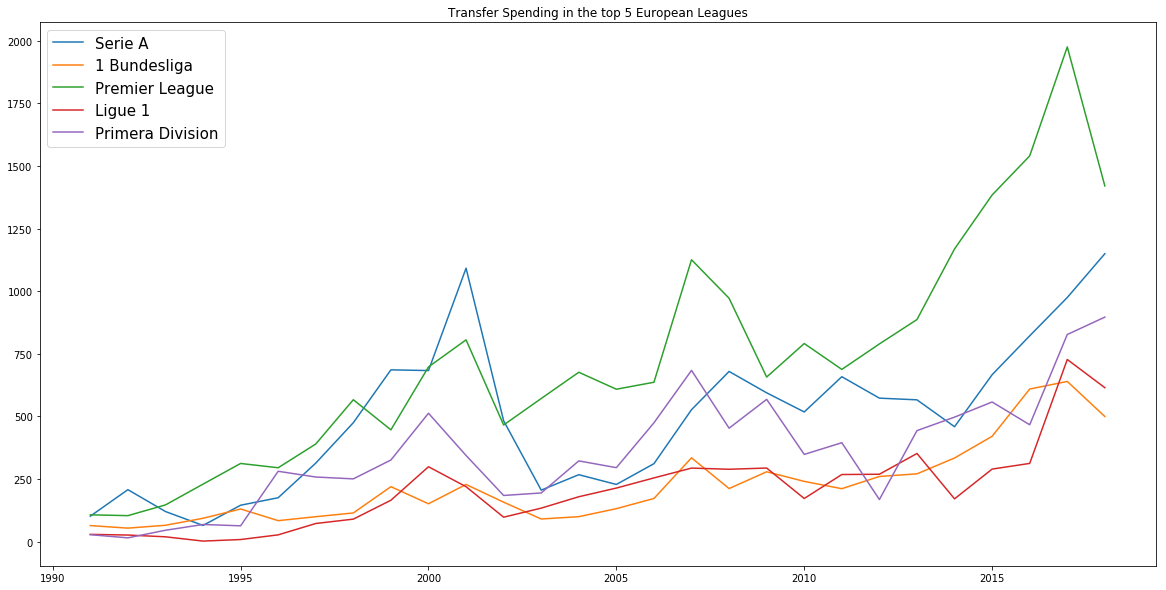

In [328]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for l in ['Serie A', '1 Bundesliga', 'Premier League', 'Ligue 1','Primera Division']:
    x = df[df["league_name"]==l]
    plt.plot(x["year"], x["total_spending in £million"],label=l)
plt.legend(prop={'size': 15})
plt.title("Transfer Spending in the top 5 European Leagues")


### Results
- Transfer spending has been steadily increasing for all European leagues since 1991
- The spending gap between Premier League and the others  shows a steep increase since the 2010.
- The percentage change in median price of player from 1990’s to 2018 is 521%

## Q 2.1. Which clubs spend the most on players from 2010-2018?

### SQL Query - sum(transfer_fee) and group by club_name and order by descending

In [332]:
topSpenders = pd.read_sql_query("SELECT club_name,league_name,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       year>2010 and year<2019\
                       group by club_name,league_name order by `total_spending in £million` desc",cnx)
topSpenders = topSpenders.head(10)
topSpenders.head(10)

,club_name,league_name,total_spending in £million
0,Manchester City,Premier League,1091.67252
1,Chelsea FC,Premier League,1043.53560
2,Paris Saint-Germain,Ligue 1,999.81630
3,Manchester United,Premier League,957.71340
4,Juventus FC,Serie A,954.37664
5,FC Barcelona,Primera Division,931.91810
6,Liverpool FC,Premier League,877.93216
7,AS Roma,Serie A,682.37935
8,Real Madrid,Primera Division,673.22300
9,Atlético Madrid,Primera Division,617.01605


### Plot

<BarContainer object of 10 artists>

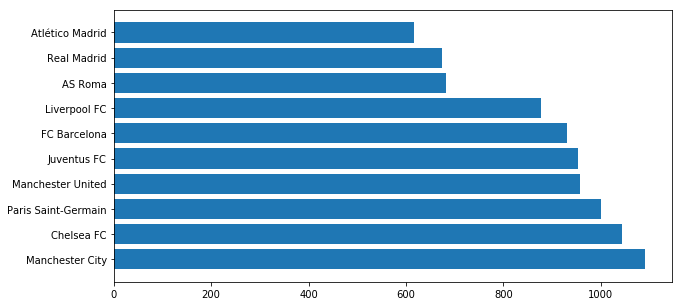

In [333]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(topSpenders["club_name"],topSpenders["total_spending in £million"])

## Q 2.2: Which clubs receive the highest transfer fees for their players?

### SQL Query - sum(transfer_fee) over outgoing transfers and group by club_name and order by descending

In [334]:
highestReceivers = pd.read_sql_query("SELECT club_involved_name,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       year>=2010 and year<=2019\
                       group by club_involved_name order by `total_spending in £million` desc",cnx).head(10)
highestReceivers = highestReceivers.head(10)
highestReceivers.head(10)

,club_involved_name,total_spending in £million
0,Monaco,820.47040
1,Liverpool,623.73035
2,Benfica,592.63320
3,AS Roma,575.96250
4,Chelsea,562.63528
5,Juventus,536.67727
6,Real Madrid,501.64515
7,Bor. Dortmund,500.77116
8,FC Barcelona,467.06210
9,Spurs,460.68439


### Plot

<BarContainer object of 10 artists>

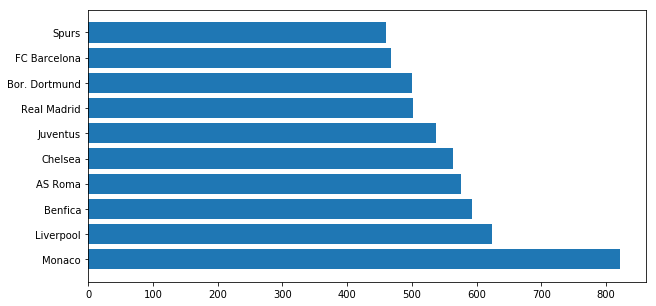

In [335]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(highestReceivers["club_involved_name"],highestReceivers["total_spending in £million"])

### Results

- The highest spending clubs are Manchester City, Chelsea and PSG. It would be interesting to know how the transfer trends have changed for these three clubs
- The club with highest transfer fees received is Monaco a relatively small club from Ligue 1 (France). We also notice Benfica another club from Liga Nos (Portugal) that receives high transfer fees. This goes to show that the club spending the highest doesn't necessarily sell their players for a high value
- 4 of the top 10 highest spending clubs are from the English Premier League, which leads us into the next question. 

## Q3. How have the transfers flowed betwen the leagues from 2010-2018?

### We create a new temporary table 'movements' with the following columns: from_league, fee_spent and to_league

In [336]:
### To find out the movement of money across the leagues, we create a temporary table
df = pd.read_sql_query("select t1.league_name as 'to_league',fee_inflation_adjusted,b.league_name as 'from_league' from transfers t1 left outer join (select club_name,league_name from transfers \
                        where league_name!='Championship' and year>=2010 \
                        group by club_name,league_name) as b on t1.club_involved_name = b.club_name where t1.year>=2010",cnx);

df.to_sql("movements", cnx, if_exists='append', index=False)



In [337]:
movements = pd.read_sql_query("select to_league,sum(fee_inflation_adjusted),from_league from movements where \
                                from_league is not null and to_league!=from_league group by to_league,from_league",cnx)
movements.head(5)

,to_league,sum(fee_inflation_adjusted),from_league
0,1 Bundesliga,63.0353,Eredivisie
1,1 Bundesliga,4.2588,Liga Nos
2,1 Bundesliga,78.6060,Ligue 1
3,1 Bundesliga,7.9515,Premier League
4,1 Bundesliga,190.0360,Primera Division


### The above data is loaded into a sankey diagram written in javascript, the visualization is displayed below. Code for the visualization can be found at https://codepen.io/tharunsikhinam/pen/QWwbzKj

In [111]:
# Display the associated webpage in a new window
import IPython
url = 'https://codepen.io/tharunsikhinam/full/QWwbzKj'
iframe = '<iframe src=' + url + ' width=1000 height=700></iframe>'
IPython.display.HTML(iframe)

### Results
- The league importing the maximum talent is the English Premier League. This also explains the high transfer spending in that league.
- The league exporting most talent is La Liga (Spain). The Spanish League exports players to nearly all leagues with the highest being to English Premier League. 

## Q 4: How has the wealth gap changed amongst the European elite?

### For this part of the analysis we will be only focussing on the top 5 European leagues

In [339]:
leagues = ['Primera Division', 'Serie A', '1 Bundesliga', 'Premier League','Ligue 1']

### To evaluate the wealth gap
### - We collect top 5 spenders in each league and calculate their transfer spending over the years
### - We collect the bottom 15 in the league and calculate their transfer spendings over the years
### - The above two measures are plotted on a graph

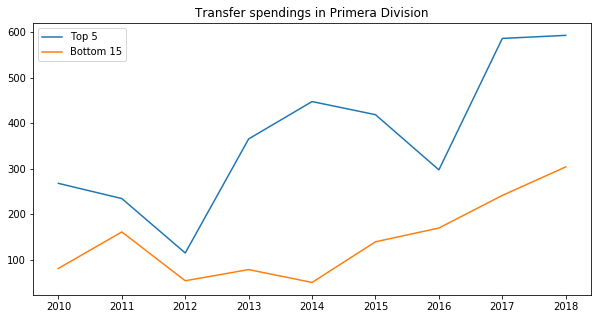

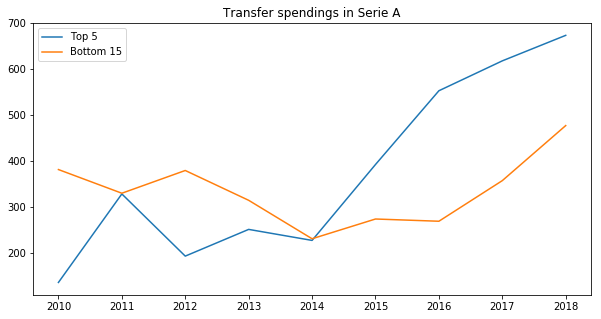

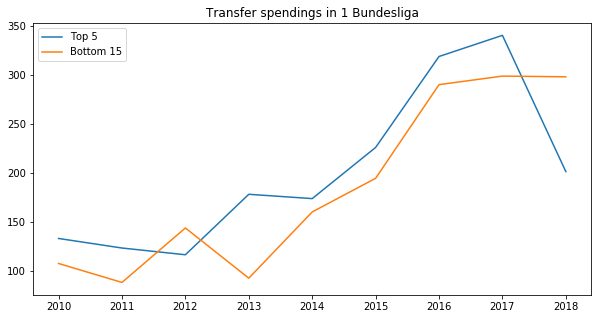

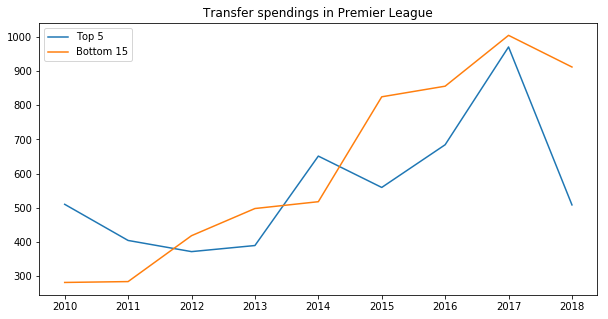

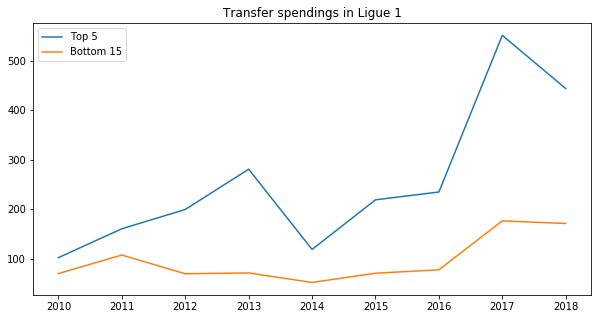

In [340]:
i=120;
for l in leagues:
    plt.figure()
    # Query to get spendings of top 5 clubs in a league
    df = pd.read_sql_query("select '"+l+"' ,year,sum(fee_inflation_adjusted) from transfers where club_name in\
(select club_name from transfers where league_name='"+l+"'\
and year>=2010 \
group by club_name order by sum(fee_cleaned) desc limit 5) and league_name='"+l+"'\
and year>=2010 group by year",cnx)
    plt.plot(df["year"], df["sum(fee_inflation_adjusted)"],label="Top 5")
    
    # Query to get spendings of bottom 15 clubs in a league
    df = pd.read_sql_query("select '"+l+"' ,year,sum(fee_inflation_adjusted) from transfers where club_name not in\
(select club_name from transfers where league_name='"+l+"'\
and year>=2010 \
group by club_name order by sum(fee_cleaned) desc limit 5) and league_name='"+l+"'\
and year>=2010 group by year",cnx)
    plt.title("Transfer spendings in " + l )
    plt.plot(df["year"], df["sum(fee_inflation_adjusted)"],label="Bottom 15")
    plt.legend()
  

### Results
- We observe a huge wealth inequality between the top and bottom clubs in Ligue 1, Serie A and Primera Division
- The difference is not so significant for English Premier League and the Bundesliga
- This is still a cause for concern since the top 5 clubs hold a disproportionate share of wealth in the top flight clubs
- These top 5 clubs in their respective leagues have won the domestic or international titles since 2010 (except for Leicester City in 2016).
- High transfer spending for domestic and international performance can lead to inequality between leagues and clubs. 

## Q5: Investigating the spending trends of Manchester City, Chelsea and Paris Saint-Germain

### We are particularly interested in the spending trends of the above 3 clubs. They have arrived into the footballing scene relatively recently and have gone on to challenge the European Elite.

#### Calculate transfer spendings over the years for the above clubs

In [285]:
df = pd.read_sql_query("select club_name,year,sum(fee_inflation_adjusted) as `transfer_fee_total` from transfers\
                    where club_name in ('Manchester City','Chelsea FC','Paris Saint-Germain') and year<=2017\
                    group by club_name,year",cnx)
df.head(5)

,club_name,year,transfer_fee_total
0,Chelsea FC,1991,7.52112
1,Chelsea FC,1992,5.37132
2,Chelsea FC,1993,6.82014
3,Chelsea FC,1994,10.70880
4,Chelsea FC,1995,3.23190


### For this question, Tableau was used to create the visualization. The Tableau file for the visualization can be found at clubsSpending.twb. 

- Chelsea, Manchester City and PSG have challenged the European elite in the past decade partly due to their huge spending
- Chelsea’s investment grew by over 234%, while Paris Saint Germain’s by 477% and Manchester City’s by 621% 
- The huge transfer spendings can be attributed to the massive amounts of foreign investment into clubs

<b>Amount & time to first title</b>
- Chelsea - £470.5 million (2 yrs)
- Manchester City - £761 million (5 yrs)
- Paris SaintGermain - £421 million  (2 ys)

## Q 6: Players from which country produce the best footballing talent?

### Following steps are performed to decide which country produces the best kind of footballing talent
- Iterate over the years 2000-2018
- Iterate over chosen positions
- Sum transfer fee by nation 
- Rank countries in descending order of transfer spending
- Compute median rank over the years
- Sort by median rank and display for each position
- Disregard countries that appear in the top 10 rankings only 10 times in the 18 year span

In [341]:
clean  = raw
positions=['Forward', 'Midfield', 'Winger', 'Defense',
       'Goalkeeper']

final = {}
#Iterate over the years
for i in range(2000,2019):
    # Iterate over positions
    for pos in positions:
        if pos not in final:
            final[pos]=pd.DataFrame()
        # Sum over the fee by nation and rank 
        x = clean[(clean["posNew"]==pos)&(clean["year"]==i)].groupby(['nat'])['fee_cleaned'].agg('sum').rank(ascending=False).sort_values(ascending=True)
        x = x.to_frame()
        x["year"]=i
        final[pos]= final[pos].append(x)
# Add column to maintain counts
for pos in positions:
    final[pos]["count"]=1
    
# Compute median and display countries by rank in ascending order 
for pos in positions:
    z = final[pos].groupby('nat').median().reset_index()
    z1 = final[pos].groupby(['nat']).agg({"count":"count","fee_cleaned": "median",})
    print(pos)
    print(z1[z1["count"]>=10].sort_values(by="fee_cleaned").head(5))
    print("\n\n")

Forward
           count  fee_cleaned
nat                          
Argentina     19          3.0
Italy         19          3.0
Spain         18          4.0
France        19          5.0
Brazil        19          5.0



Midfield
         count  fee_cleaned
nat                        
Brazil      19          2.0
France      19          3.0
Spain       19          4.0
England     19          4.0
Italy       19          4.0



Winger
             count  fee_cleaned
nat                            
France          18          3.0
Spain           19          4.0
Netherlands     19          5.0
Portugal        18          5.5
England         16          6.5



Defense
         count  fee_cleaned
nat                        
Italy       19          2.0
Brazil      19          3.0
France      19          3.0
England     19          3.0
Spain       17          5.0



Goalkeeper
         count  fee_cleaned
nat                        
Italy       17          3.0
England     18          3.5
Brazil 

## Conclusion

- By analyzing the transfer market we are now aware of some of the big spenders in the European leagues and the inflation in transfer fees in the English Premier League

- With clubs raking in huge amounts of revenue, checks and balances need to be put into place to prevent the sport from being dominated from a few European elite clubs. which could lead to an European Super League

- High transfer spending for domestic and international performance can lead to wealth inequality between leagues and clubs. 

- The increase in foreign investments into European Clubs has led to the rise of super-rich clubs
